In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

# devemos primeiramente ler o dataset e separar as amostras dos rótulos
df = pd.read_excel('data/Dry_Bean_Dataset.xlsx')
x = df.iloc[:, :-1] # tirar a ultima coluna
y = df.iloc[:, -1]  # somente ultima coluna (rotulos)

print(f'Rótulos originais: {y.unique()}')

# trocar rotulos em texto para números
label_to_int = LabelEncoder()
y_int = label_to_int.fit_transform(y)

# trocando os rotulos no dataframe
df.iloc[:, -1] = y_int
# print(df.head())

print(f'Rótulos em números: {y.unique()}')

2023-07-13 13:18:03.315859: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 13:18:03.350059: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 13:18:03.350762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 13:18:03.944211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Rótulos originais: ['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']
Rótulos em números: [5 0 1 2 4 6 3]


In [2]:
# devemos separar o dataset em 3 conjuntos: treino, validacao e testes
# para isso utilizaremos a tecnica do sklearn para dividir os conjuntos de forma balanceada

# dividir primeiro entre treinamento(treino e validacao) e teste
x_trainval, x_test, y_trainval, y_test = train_test_split(x, y, test_size=0.1, 
                                                          stratify=y)
# dividir o conjunto de treinamento entre treino e validacao
x_train, x_val, y_train, y_val = train_test_split(x_trainval, y_trainval, test_size=0.2, 
                                                  stratify=y_trainval)

print(f'Número de amostras do dataset: {len(x)} (100%)')
print(f'Tamanho do conjunto de treino: {len(x_train)} ({round(len(x_train)*100/len(x),2)}%)')
print(f'Tamanho do conjunto de validacao: {len(x_val)} ({round(len(x_val)*100/len(x),2)}%)')
print(f'Tamanho do conjunto de testes: {len(x_test)} ({round(len(x_test)*100/len(x),2)}%)')

# converter os valores para tensores aceitos no TensorFlow
# para os rotulos, e necessario adaptar para one-hot-encoding
# codificacao aceita pelo tensorflow para identificar as classes
x_train = tf.convert_to_tensor(x_train.values)
y_train = tf.keras.utils.to_categorical(y_train)
x_val = tf.convert_to_tensor(x_val.values)
y_val = tf.keras.utils.to_categorical(y_val)
x_test = tf.convert_to_tensor(x_test.values)
y_test = tf.keras.utils.to_categorical(y_test)

Número de amostras do dataset: 13611 (100%)
Tamanho do conjunto de treino: 9799 (71.99%)
Tamanho do conjunto de validacao: 2450 (18.0%)
Tamanho do conjunto de testes: 1362 (10.01%)


2023-07-13 13:18:05.950435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-13 13:18:05.950977: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# definir o numero de epocas e o tamanho do batch
n_epochs = 600
batch_size = 64

# criar o modelo
model = tf.keras.Sequential()
# numero de features de cada amostra para ser a entrada da rede
# print(x_train.shape[1])
model.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(len(y.unique()), activation='softmax'))

# compilar o modelo
# otimizador adam para a taxa de aprendizado
# definindo a perda como a entropia cruzada para o modelo e a metrica de avaliacao como acuracia do modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

# treinar o modelo
# shuffle=True faz com que os batchs de treinamento sejam randomizados a cada epoca, para tornar menos provável o overfitting
# verbose=False/True para plotar ou não as saídas a cada época
historico = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=n_epochs, batch_size=batch_size, shuffle=True, verbose=True)
train_accuracy = historico.history['accuracy']
val_accuracy = historico.history['val_accuracy']
train_loss = historico.history['loss']
val_loss = historico.history['val_loss']
train_mse = historico.history['mse']
val_mse = historico.history['val_mse']
print(train_accuracy)
print(val_accuracy)


# Avaliar o modelo no conjunto de teste
loss, accuracy, mse = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test MSE:", mse)

Epoch 1/600
154/154 [==============================] - 1s 2ms/step - loss: 2233.0188 - accuracy: 0.1823 - mse: 0.2300 - val_loss: 37.1304 - val_accuracy: 0.2404 - val_mse: 0.2102
Epoch 2/600
154/154 [==============================] - 0s 1ms/step - loss: 41.2722 - accuracy: 0.2507 - mse: 0.2075 - val_loss: 39.9354 - val_accuracy: 0.1624 - val_mse: 0.2366
Epoch 3/600
154/154 [==============================] - 0s 1ms/step - loss: 53.3733 - accuracy: 0.2418 - mse: 0.2118 - val_loss: 47.7615 - val_accuracy: 0.3269 - val_mse: 0.1895
Epoch 4/600
154/154 [==============================] - 0s 1ms/step - loss: 45.9839 - accuracy: 0.2433 - mse: 0.2108 - val_loss: 70.8938 - val_accuracy: 0.1176 - val_mse: 0.2519
Epoch 5/600
154/154 [==============================] - 0s 1ms/step - loss: 47.0173 - accuracy: 0.2684 - mse: 0.2037 - val_loss: 53.7012 - val_accuracy: 0.3710 - val_mse: 0.1752
Epoch 6/600
154/154 [==============================] - 0s 1ms/step - loss: 42.7085 - accuracy: 0.2725 - mse: 0.20

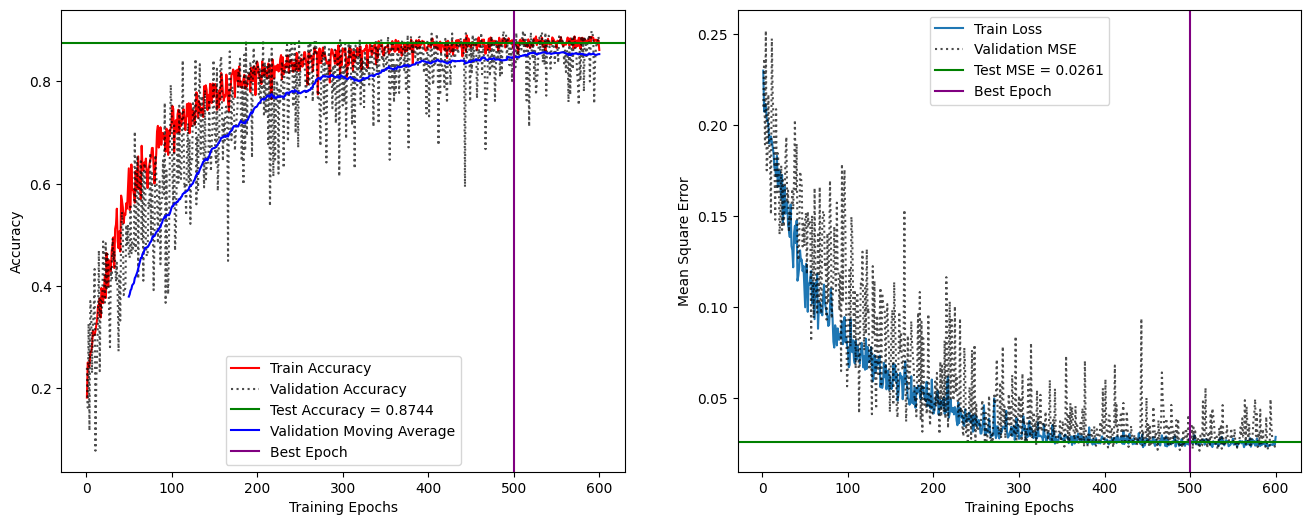

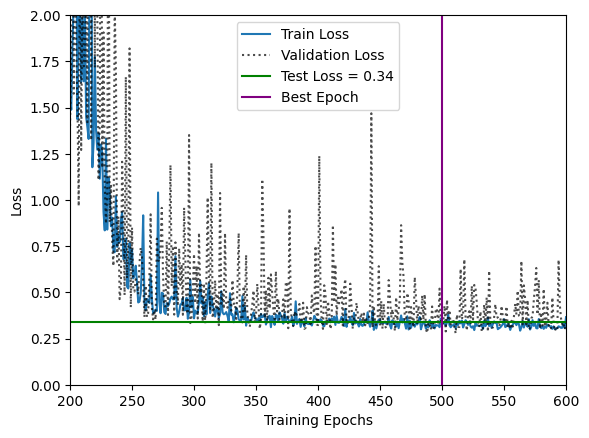

In [8]:
import matplotlib.pyplot as plt
# plot da precisão e perda do modelo

# criando média móvel do conjunto de validação para plotar
data = pd.DataFrame(val_accuracy, columns=['val_accuracy'])
data['average10epochs'] = data.val_accuracy.rolling(50).mean()
# print(data.head(10))
 

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.plot(range(1, n_epochs+1), train_accuracy, color='red')
ax1.plot(range(1, n_epochs+1), val_accuracy, color='black', linestyle=':' , alpha=0.7)
ax1.axhline(accuracy, color='green')
ax1.plot(range(1, n_epochs+1), data['average10epochs'], color='blue')
ax1.axvline(500, color='purple')
ax1.set_xlabel('Training Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['Train Accuracy', 'Validation Accuracy', f'Test Accuracy = {round(accuracy,4)}', 'Validation Moving Average', 'Best Epoch'])

ax2.plot(range(1, n_epochs+1), train_mse)
ax2.plot(range(1, n_epochs+1), val_mse, color='black', linestyle=':', alpha=0.7)
ax2.axhline(mse, color='green')
ax2.axvline(500, color='purple')
ax2.set_xlabel('Training Epochs')
ax2.set_ylabel('Mean Square Error')
ax2.legend(['Train Loss', 'Validation MSE', f'Test MSE = {round(mse,4)}', 'Best Epoch'])
# ax2.set_ylim(0,50)

plt.figure()
plt.plot(range(1, n_epochs+1), train_loss, label='Train Loss')
plt.plot(range(1, n_epochs+1), val_loss, label='Validation Loss', color='black', linestyle=':', alpha=0.7)
plt.axhline(loss, color='green', label=f'Test Loss = {round(loss,4)}')
plt.axvline(500, color='purple', label='Best Epoch')
plt.ylim(0,2)
plt.xlim(200,600)
plt.xlabel('Training Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

43/43 [==============================] - 0s 576us/step
Classes: [0 1 2 3 4 5 6]


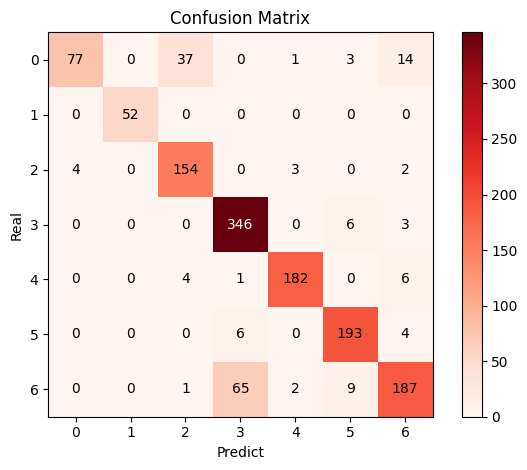

In [5]:
# fazer previsoes no conjunto de teste e converter as probabilidades em classes
y_pred = model.predict(x_test)             # probabilidades
y_pred_labels = np.argmax(y_pred, axis=1)  # capturar o argumento da maior probabilidade = classe

# classes originais - y_test(one-hot-encoding) - transformar em classes int
y_test_labels = np.argmax(y_test, axis=1)

# calcular a matriz de confusão
cm = confusion_matrix(y_test_labels, y_pred_labels)

classes = np.unique(y_test_labels)
print(f'Classes: {classes}')

# plotar a matriz de confusao
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adicionar valores aos quadrados da matriz de confusao
lim_color_black = 200  # mudar cor da letra para branco caso a cor do vermelho fique muito escura
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > lim_color_black else "black")

plt.ylabel('Real')
plt.xlabel('Predict')
plt.tight_layout()
plt.show()